In [1]:
from src.myprogram import MyModel
import time
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from tqdm.notebook import tqdm
import gc

In [2]:
work_dir = 'work'
test_data_dir = 'eval_data/input_long.txt'
test_output_dir = 'eval_data/pred_long.txt'

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import gc

def benchmark_model(work_dir, test_data_dir, test_output_dir, num_runs=5, warmup_runs=1):
    """
    Run benchmarks on model phases and full execution.
    Returns statistics and a visualization.
    """
    # Initialize timing dictionaries
    phase_times = {
        'Load Model': [],
        'Load Test Data': [],
        'Make Predictions': [],
        'Write Predictions': []
    }
    full_times = []
    
    # Perform warmup run
    if warmup_runs > 0:
        print(f"Performing {warmup_runs} warmup run(s)...")
        for _ in range(warmup_runs):
            model = MyModel.load(work_dir=work_dir)
            test_data = MyModel.load_test_data(test_data_dir)
            pred = model.run_pred(test_data)
            model.write_pred(pred, test_output_dir)
            del model, test_data, pred
            gc.collect()
    
    # Run individual phase benchmarks
    print(f"Running {num_runs} benchmark iterations...")
    for i in range(num_runs):
        # Full execution timing
        gc.collect()
        start_time = time.perf_counter()
        model = MyModel.load(work_dir=work_dir)
        test_data = MyModel.load_test_data(test_data_dir)
        pred = model.run_pred(test_data)
        model.write_pred(pred, test_output_dir)
        full_times.append(time.perf_counter() - start_time)
        
        # Cleanup
        del model, test_data, pred
        gc.collect()
        
        # Individual phase timing
        gc.collect()
        start_time = time.perf_counter()
        model = MyModel.load(work_dir=work_dir)
        phase_times['Load Model'].append(time.perf_counter() - start_time)
        
        gc.collect()
        start_time = time.perf_counter()
        test_data = MyModel.load_test_data(test_data_dir)
        phase_times['Load Test Data'].append(time.perf_counter() - start_time)
        
        gc.collect()
        start_time = time.perf_counter()
        pred = model.run_pred(test_data)
        phase_times['Make Predictions'].append(time.perf_counter() - start_time)
        
        gc.collect()
        start_time = time.perf_counter()
        model.write_pred(pred, test_output_dir)
        phase_times['Write Predictions'].append(time.perf_counter() - start_time)
        
        # Cleanup
        del model, test_data, pred
        gc.collect()
    
    # Calculate statistics
    stats = {}
    for phase, times in phase_times.items():
        stats[phase] = {
            'mean': np.mean(times),
            'median': np.median(times),
            'std': np.std(times),
            'min': np.min(times),
            'max': np.max(times),
            'times': times
        }
    
    full_stats = {
        'mean': np.mean(full_times),
        'median': np.median(full_times),
        'std': np.std(full_times),
        'min': np.min(full_times),
        'max': np.max(full_times),
        'times': full_times
    }
    
    # Create visualization
    fig = plot_results(stats, full_stats, output_file=None)
    
    return {
        'phase_stats': stats,
        'full_stats': full_stats,
        'plot': fig
    }

def plot_results(stats, full_stats, output_file=None):
    """Create bar chart and pie chart visualization."""
    phases = list(stats.keys())
    mean_times = [stats[phase]['mean'] for phase in phases]
    std_times = [stats[phase]['std'] for phase in phases]
    
    # Add summary bars
    phases.extend(['Sum of Phases', 'Full Execution'])
    sum_phases = sum(mean_times)
    mean_times.extend([sum_phases, full_stats['mean']])
    std_times.extend([0, full_stats['std']])  # No std for sum
    
    # Calculate percentages for pie chart (only individual phases)
    total_time = sum(mean_times[:len(stats)])
    percentages = [time/total_time*100 for time in mean_times[:len(stats)]]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar chart - use different colors for phases vs summary
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12'] + ['#9b59b6', '#34495e']
    bars = ax1.bar(phases, mean_times, yerr=std_times, capsize=5, color=colors)
    
    # Add values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        yerr = std_times[i] if i < len(std_times) else 0
        ax1.text(bar.get_x() + bar.get_width()/2., height + yerr + 0.01,
                f'{height:.3f}s', ha='center', va='bottom', fontsize=10)
    
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Execution Time by Phase', pad=20)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Rotate x-labels if they're too long
    plt.setp(ax1.get_xticklabels(), rotation=15, ha='right')
    
    # Pie chart (only individual phases)
    ax2.pie(mean_times[:len(stats)], labels=phases[:len(stats)], 
            autopct='%1.1f%%', colors=colors[:len(stats)], 
            shadow=True, startangle=90)
    ax2.axis('equal')
    ax2.set_title('Proportion of Execution Time by Phase', pad=20)
    
    # Calculate overhead between full and sum
    overhead = full_stats['mean'] - sum_phases
    overhead_pct = (overhead / sum_phases) * 100
    overhead_text = f"Overhead: {overhead:.3f}s ({overhead_pct:.1f}%)"
    
    # Add overhead annotation to the bar chart
    ax1.annotate(overhead_text, 
                xy=(len(phases)-1.5, (sum_phases + full_stats['mean'])/2),
                xycoords='data',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                ha='center')
    
    plt.tight_layout(pad=2.0)
    
    # Save figure if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig

Running 10 benchmark iterations...


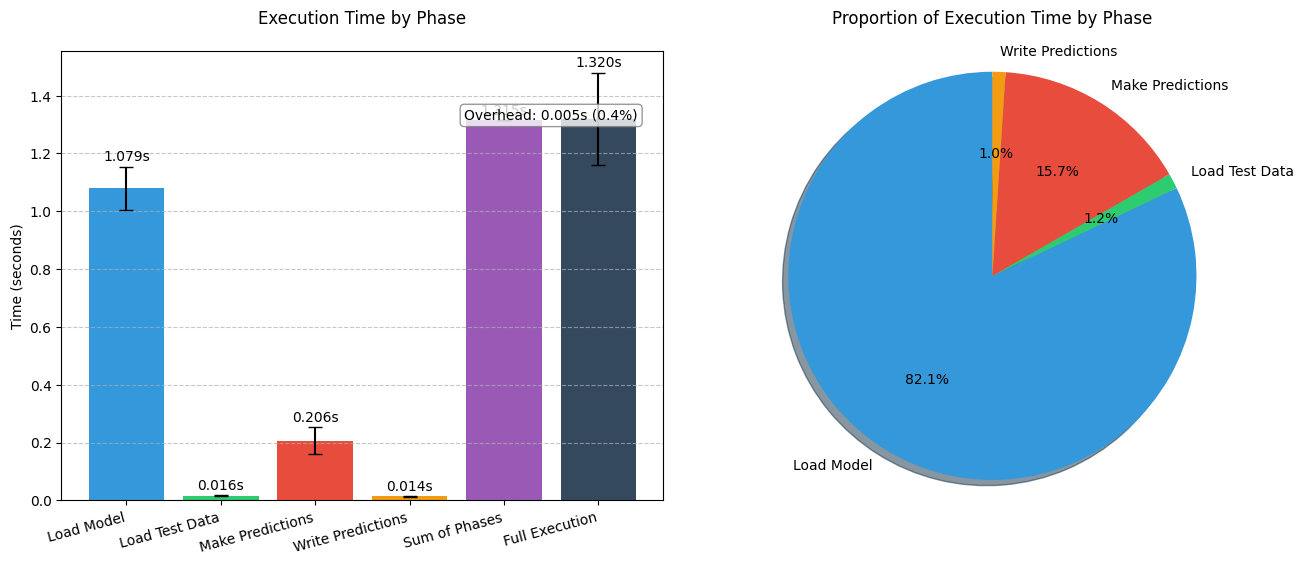

In [5]:
import matplotlib.pyplot as plt
import os

# Define paths
work_dir = 'work'
test_data_dir = 'eval_data/input_long.txt'
test_output_dir = 'eval_data/pred_long.txt'

# Create output directory if it doesn't exist
os.makedirs('benchmark_results', exist_ok=True)

# Run the benchmark with custom settings
results = benchmark_model(
    work_dir=work_dir,
    test_data_dir=test_data_dir,
    test_output_dir=test_output_dir,
    num_runs=10,           # Fewer runs for faster results during development
    warmup_runs=0         # One warmup run to stabilize performance
)

# Extract the raw data
phase_stats = results['phase_stats']
full_stats = results['full_stats']

# Save the figure
fig = results['plot']
output_path = 'benchmark_results/tmp.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()